In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:,.2f}'.format)  # ,0f تعني بدون كسور
pd.set_option('display.max_rows', 10)  # عرض جميع الصفوف
import plotly.express as px
import plotly.graph_objects as go

## 📂 1. Loading Data

In [5]:
df = pd.read_excel("Online Retail.xlsx", engine='openpyxl')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,"541,909.00",541909,"541,909.00","406,829.00"
mean,9.55,2011-07-04 13:34:57.156386048,4.61,"15,287.69"
min,"-80,995.00",2010-12-01 08:26:00,"-11,062.06","12,346.00"
25%,1.00,2011-03-28 11:34:00,1.25,"13,953.00"
50%,3.00,2011-07-19 17:17:00,2.08,"15,152.00"
75%,10.00,2011-10-19 11:27:00,4.13,"16,791.00"
max,"80,995.00",2011-12-09 12:50:00,"38,970.00","18,287.00"
std,218.08,NaN,96.76,"1,713.60"


In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## 🧹 2. Data Cleaning

- Removed null values.
- Removed useless values.
- Removed duplicates.
- Created new columns.
- Drop rows with missing CustomerIDs

In [9]:
# Removing Null values in descrption column and the corresponding values in the customer id column because the UnitPrice for both are 0 so it's recommended to drop them.
df = df.dropna(subset=['Description'])
# Remove rows where the price column equals 0
df.drop(df[df['UnitPrice'] == 0].index, inplace=True) 

In [10]:
# Remove useless rows with admin fees and other charges  
keywords = ['sample', 'AMAZON fee', 'postage', 'charges', 'manual', 'amazon', 'cruk', 'adjust','Discount']
df = df[~df['Description'].str.contains('|'.join(keywords), case=False)]

In [11]:
# Remove duplicates
df.drop_duplicates(subset=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID'], inplace=True)

In [12]:
# Creating new columns
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df['Date'] = df['InvoiceDate'].dt.date
df['Year'] = df['InvoiceDate'].dt.year
df['Quarter'] = df['InvoiceDate'].dt.quarter
df['Month'] = df['InvoiceDate'].dt.month
df['WeekDay'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

In [13]:
# Find invoices with missing CustomerIDs
unknown_ids = df[df['CustomerID'].isnull()][['InvoiceNo', 'CustomerID']].drop_duplicates()
# Find invoices with known CustomerIDs
known_ids = df[df['CustomerID'].notnull()][['InvoiceNo', 'CustomerID']].drop_duplicates()
# Merge to try filling missing values of CustomerIDs
result = pd.merge(known_ids, unknown_ids, on ='InvoiceNo', how ='right')
# Solution failed because the CustomerID is not unique for each invoice, so we will drop the rows with missing CustomerIDs
df.dropna(subset=['CustomerID'], inplace=True)

## 🔍 3. Exploratory Data Analysis   


### 3.1 Product Analysis

In [14]:
# Top 10 products by Quantity
top_10_products_by_Quantity = df[df['Quantity'] > 0].groupby(by='Description')['Quantity'].sum().sort_values(ascending=False).head(10).reset_index().rename(columns={'Quantity': 'TotalSold'})
top_10_products_by_Quantity

,Description,TotalSold
0,"PAPER CRAFT , LITTLE BIRDIE",80995
1,MEDIUM CERAMIC TOP STORAGE JAR,77916
2,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54319
3,JUMBO BAG RED RETROSPOT,46078
4,WHITE HANGING HEART T-LIGHT HOLDER,36706
5,ASSORTED COLOUR BIRD ORNAMENT,35263
6,PACK OF 72 RETROSPOT CAKE CASES,33670
7,POPCORN HOLDER,30919
8,RABBIT NIGHT LIGHT,27153
9,MINI PAINT SET VINTAGE,26076


In [15]:
# Least 10 products by Quantity
less_10_products_by_Quantity = df[df['Quantity'] > 0].groupby(by='Description')['Quantity'].sum().sort_values().head(10).reset_index().rename(columns={'Quantity': 'TotalSold'})
less_10_products_by_Quantity


,Description,TotalSold
0,WHITE STONE/CRYSTAL EARRINGS,1
1,DOLPHIN WINDMILL,1
2,PACK 4 FLOWER/BUTTERFLY PATCHES,1
3,ORANGE FELT VASE + FLOWERS,1
4,DUSTY PINK CHRISTMAS TREE 30CM,1
5,PINK CRYSTAL GUITAR PHONE CHARM,1
6,WHITE ROSEBUD PEARL EARRINGS,1
7,NEW BAROQUE B'FLY NECKLACE PINK,1
8,NECKLACE+BRACELET SET PINK DAISY,1
9,PINK POLKADOT KIDS BAG,1


In [16]:
# Count of prices for each product
price_variation = df.groupby('Description')['UnitPrice'].nunique().reset_index().rename(columns={'UnitPrice': 'unique_prices'})
# Products with more than one price
products_with_price_variation = price_variation[price_variation['unique_prices'] > 1].sort_values(by='unique_prices', ascending=False)


### 3.2 Country Analysis

In [17]:
# Number of invoices per country
invoices_per_country = df[df['Revenue'] > 0].groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False).reset_index(name='invoice_count')
invoices_per_country

,Country,invoice_count
0,United Kingdom,16579
1,Germany,443
2,France,380
3,EIRE,258
4,Belgium,98
...,...,...
32,Czech Republic,2
33,Brazil,1
34,Lebanon,1
35,Saudi Arabia,1


In [18]:
# Sort countries by Quantity
top_10_countries_by_Quantity = df.groupby('Country')['Quantity'].sum().sort_values(ascending=False).reset_index()
top_10_countries_by_Quantity 

,Country,Quantity
0,United Kingdom,3979900
1,Netherlands,199934
2,EIRE,135939
3,Germany,116234
4,France,109019
...,...,...
32,Lebanon,386
33,Brazil,356
34,RSA,351
35,Bahrain,260


In [19]:
# Sort countries by Revenue
top_10_countries_by_Revenue = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).reset_index().rename(columns={'Revenue': 'total Revenue'})
top_10_countries_by_Revenue

,Country,total Revenue
0,United Kingdom,"6,804,020.58"
1,Netherlands,"283,479.54"
2,EIRE,"251,557.47"
3,Germany,"200,619.66"
4,France,"181,571.54"
...,...,...
32,Brazil,"1,143.60"
33,RSA,"1,002.31"
34,Czech Republic,671.72
35,Bahrain,548.40


In [20]:
# Average invoice Revenue per country
invoice_Revenue = df.groupby(['Country', 'InvoiceNo'])['Revenue'].sum().reset_index()
Average_invoice_Revenue_per_country = (invoice_Revenue.groupby('Country')['Revenue'].mean().sort_values(ascending=False).reset_index().rename(columns={'Revenue': 'avg Revenue per invoice'}))

Average_invoice_Revenue_per_country

,Country,avg Revenue per invoice
0,Netherlands,"2,952.91"
1,Singapore,"2,280.10"
2,Australia,"2,043.62"
3,Lebanon,"1,693.88"
4,Japan,"1,416.79"
...,...,...
32,Bahrain,274.20
33,USA,247.27
34,Malta,220.05
35,Czech Republic,167.93


### 3.3 Time Series Analysis

In [21]:
Revenue_by_Year = df.groupby('Year')['Revenue'].sum().reset_index()
Revenue_by_Year

,Year,Revenue
0,2010,"548,443.92"
1,2011,"7,723,669.01"


In [22]:
Revenue_by_Quarter = df.groupby(['Year','Quarter'])['Revenue'].sum().reset_index()
Revenue_by_Quarter

,Year,Quarter,Revenue
0,2010,4,"548,443.92"
1,2011,1,"1,479,636.56"
2,2011,2,"1,713,407.22"
3,2011,3,"2,116,378.60"
4,2011,4,"2,414,246.63"


In [23]:
Revenue_by_Month = df.groupby(['Year','Month'])['Revenue'].sum().reset_index()
Revenue_by_Month

,Year,Month,Revenue
0,2010,12,"548,443.92"
1,2011,1,"471,580.34"
2,2011,2,"434,218.17"
3,2011,3,"573,838.05"
4,2011,4,"421,527.77"
...,...,...,...
8,2011,8,"612,955.13"
9,2011,9,"922,708.74"
10,2011,10,"961,742.49"
11,2011,11,"1,114,202.12"


In [24]:
Revenue_by_day = df.groupby('Date')['Revenue'].sum().reset_index()
Revenue_by_day

,Date,Revenue
0,2010-12-01,"45,787.56"
1,2010-12-02,"45,623.47"
2,2010-12-03,"22,207.68"
3,2010-12-05,"30,543.61"
4,2010-12-06,"30,161.75"
...,...,...
300,2011-12-05,"55,382.24"
301,2011-12-06,"42,984.87"
302,2011-12-07,"68,347.61"
303,2011-12-08,"49,013.48"


In [25]:
Revenue_by_weekday = df.groupby('WeekDay')['Revenue'].sum().reset_index()
Revenue_by_weekday

,WeekDay,Revenue
0,Friday,"1,265,378.26"
1,Monday,"1,267,594.47"
2,Sunday,"772,780.54"
3,Thursday,"1,890,061.84"
4,Tuesday,"1,559,099.90"
5,Wednesday,"1,517,197.92"


In [26]:
Revenue_by_Hour = df.groupby('Hour')['Revenue'].sum().reset_index()
Revenue_by_Hour

,Hour,Revenue
0,6,-281.35
1,7,"30,469.32"
2,8,"276,181.11"
3,9,"645,780.27"
4,10,"1,138,673.42"
...,...,...
10,16,"442,151.78"
11,17,"211,874.77"
12,18,"100,150.88"
13,19,"44,832.64"


In [27]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=weekday_order, ordered=True)
Revenue_by_weekday['WeekDay'] = Revenue_by_weekday['WeekDay'].astype(cat_type)
Revenue_by_weekday = Revenue_by_weekday.sort_values('WeekDay')
Revenue_by_weekday

,WeekDay,Revenue
1,Monday,"1,267,594.47"
4,Tuesday,"1,559,099.90"
5,Wednesday,"1,517,197.92"
3,Thursday,"1,890,061.84"
0,Friday,"1,265,378.26"
2,Sunday,"772,780.54"


### 3.4 Invoice Analysis

In [28]:
no_invoices = df['InvoiceNo'].nunique()
no_invoices

21788

In [29]:
invoice_amount = df.groupby('InvoiceNo')['Revenue'].sum().reset_index().rename(columns={'Revenue': 'amount'})
invoice_amount

,InvoiceNo,amount
0,536365,139.12
1,536366,22.20
2,536367,278.73
3,536368,70.05
4,536369,17.85
...,...,...
21783,C581470,-8.32
21784,C581484,"-168,469.60"
21785,C581490,-32.53
21786,C581568,-54.75


### 3.5 Customer Analysis

In [30]:
# Total number of customers
no_customers = df['CustomerID'].nunique()
no_customers 

4362

In [31]:
# Revenue per customer
df_Revenue_only = df[df['Revenue'] > 0]
Revenue_per_customer = df_Revenue_only.groupby('CustomerID')['Revenue'].sum().sort_values(ascending=False).reset_index()
Revenue_per_customer

,CustomerID,Revenue
0,"14,646.00","279,138.02"
1,"18,102.00","259,657.30"
2,"17,450.00","194,390.79"
3,"16,446.00","168,472.50"
4,"14,911.00","140,336.83"
...,...,...
4329,"16,878.00",13.30
4330,"17,956.00",12.75
4331,"14,792.00",6.20
4332,"16,454.00",5.90


In [32]:
# quantity_per_customer
quantity_per_customer = df_Revenue_only[df_Revenue_only['Quantity'] > 0].groupby('CustomerID')['Quantity'].sum().sort_values(ascending=False).reset_index()
quantity_per_customer

,CustomerID,Quantity
0,"14,646.00",196844
1,"16,446.00",80997
2,"14,911.00",80238
3,"12,415.00",77373
4,"12,346.00",74215
...,...,...
4329,"14,792.00",2
4330,"16,454.00",2
4331,"15,510.00",2
4332,"16,257.00",2


In [33]:
# top products per customer
top_products_per_customer = df_Revenue_only.groupby(['CustomerID', 'Description'])['Quantity'].sum().reset_index().sort_values(['CustomerID', 'Quantity'], ascending=[True, False]).head(10)
top_products_per_customer

,CustomerID,Description,Quantity
0,"12,346.00",MEDIUM CERAMIC TOP STORAGE JAR,74215
42,"12,347.00",ICE CREAM SUNDAE LIP GLOSS,240
1,"12,347.00",3D DOG PICTURE PLAYING CARDS,126
47,"12,347.00",MINI PAINT SET VINTAGE,108
64,"12,347.00",RABBIT NIGHT LIGHT,84
4,"12,347.00",60 TEATIME FAIRY CAKE CASES,72
5,"12,347.00",72 SWEETHEART FAIRY CAKE CASES,72
71,"12,347.00",RED TOADSTOOL LED NIGHT LIGHT,72
90,"12,347.00",SMALL HEART MEASURING SPOONS,72
43,"12,347.00",LARGE HEART MEASURING SPOONS,48


In [34]:
# RFM segmentation
last_Date = df_Revenue_only['InvoiceDate'].max()
rfm = df_Revenue_only.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_Date - x.max()).days,      # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'Revenue': 'sum'                                             # Monetary
}).reset_index().rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'Revenue':'Monetary'})
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,"12,346.00",325,1,"77,183.60"
1,"12,347.00",1,7,"4,310.00"
2,"12,348.00",74,4,"1,437.24"
3,"12,349.00",18,1,"1,457.55"
4,"12,350.00",309,1,294.40


In [35]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm[['R_score', 'F_score', 'M_score']] = rfm[['R_score', 'F_score', 'M_score']].astype(int)

def segment_customer(df):
    r, f, m = df['R_score'], df['F_score'], df['M_score']
    
    if r >= 4 and f >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3:
        return 'Loyal Customers'
    elif r >= 4 and f <= 2:
        return 'Potential Loyalist'
    elif r == 3 and f <= 2:
        return 'Need Attention'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    elif r == 1 and f == 1:
        return 'Lost Customers'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
print(rfm['Segment'].value_counts())

Segment
Champions             1136
Loyal Customers        827
Others                 706
At Risk                637
Lost Customers         362
Need Attention         347
Potential Loyalist     319
Name: count, dtype: int64


In [36]:
# The number of products purchased by each customer
customer_product_count = df.groupby('CustomerID')['Description'].nunique().reset_index().rename(columns={'Description': 'unique_products_bought'}).sort_values(by='unique_products_bought', ascending=False)

customer_product_count.head(5)

,CustomerID,unique_products_bought
1891,"14,911.00",1822
328,"12,748.00",1777
4033,"17,841.00",1352
1296,"14,096.00",1128
1443,"14,298.00",891


In [37]:
# The products customers buy most regularly
product_customer_freq = df.groupby(['Description', 'CustomerID'])['InvoiceNo'].nunique().reset_index()
product_customer_freq = product_customer_freq[product_customer_freq['InvoiceNo'] > 1]
most_frequent_products = product_customer_freq.groupby('Description')['CustomerID'].count().sort_values(ascending=False).reset_index().rename(columns={'CustomerID': 'loyal_customers_count'})
most_frequent_products.head(10)

,Description,loyal_customers_count
0,WHITE HANGING HEART T-LIGHT HOLDER,414
1,REGENCY CAKESTAND 3 TIER,363
2,JUMBO BAG RED RETROSPOT,317
3,ASSORTED COLOUR BIRD ORNAMENT,294
4,LUNCH BAG RED RETROSPOT,284
5,PARTY BUNTING,282
6,SET OF 3 CAKE TINS PANTRY DESIGN,249
7,LUNCH BAG BLACK SKULL.,233
8,LUNCH BAG CARS BLUE,210
9,SPOTTY BUNTING,209


In [38]:
# Top loyal customers per product
top_customers_per_product = df.groupby(['Description', 'CustomerID'])['Quantity'].sum().reset_index().sort_values(['Description', 'Quantity'], ascending=[True, False])
top_customers_per_product.head(5)

,Description,CustomerID,Quantity
22,4 PURPLE FLOCK DINNER CANDLES,"17,315.00",24
27,4 PURPLE FLOCK DINNER CANDLES,"18,055.00",16
3,4 PURPLE FLOCK DINNER CANDLES,"13,949.00",12
13,4 PURPLE FLOCK DINNER CANDLES,"15,621.00",12
19,4 PURPLE FLOCK DINNER CANDLES,"16,779.00",12


### 3.6 Returns Analysis

In [102]:
# Filter only returns (where Quantity is negative)
returns_df = df[df['Quantity'] < 0].copy()

# Count of returns
total_returns = returns_df.shape[0]

# Total financial impact of returns
returns_df["ReturnValue"] = returns_df["Quantity"] * returns_df["UnitPrice"]
total_return_value = returns_df["ReturnValue"].sum()

In [103]:
# Convert InvoiceDate to InvoiceDatetime if not already
returns_df['InvoiceDate'] = pd.to_datetime(returns_df['InvoiceDate'])

# Set InvoiceDatetime index
returns_df.set_index('InvoiceDate', inplace=True)

# Resample by month
monthly_returns = returns_df.resample('ME').sum(numeric_only=True)['ReturnValue']

In [104]:
# Most returned products (by count)
top_returned_products = returns_df.groupby('Description')['Quantity'].sum().sort_values().head(10)  # Most negative

In [105]:
# Top countries by return count
returns_by_country = returns_df.groupby('Country')['Quantity'].count().sort_values(ascending=False).head(10)

In [106]:
# returns by Customers  
returns_by_Customers = returns_df.groupby('CustomerID')['ReturnValue'].sum().sort_values().head(10)

## 🎨 4. Visualizations 

#### 4.1 Time series Visuals 

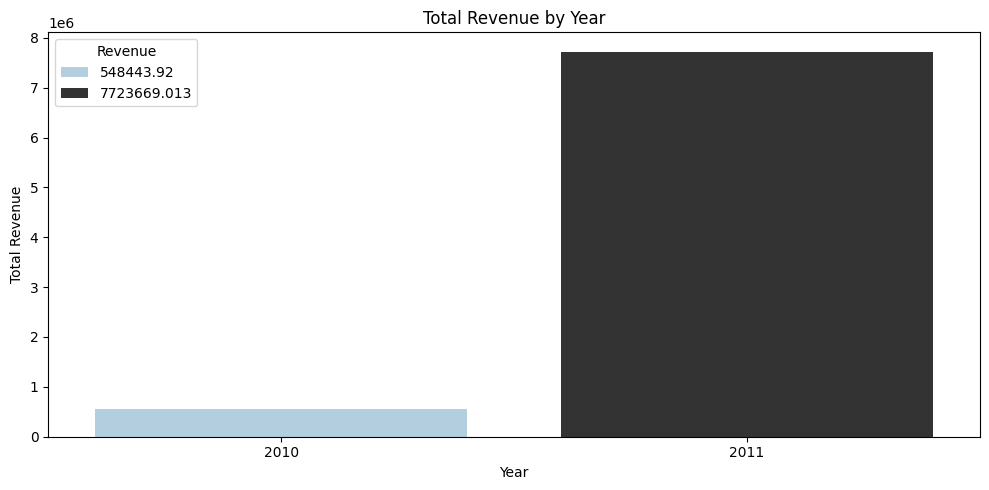

In [107]:
# Yearly Revenue
plt.figure(figsize=(10, 5))
sns.barplot(data=Revenue_by_Year, x='Year', y='Revenue', hue='Revenue',palette='Blues_d')
plt.title('Total Revenue by Year')
plt.ylabel('Total Revenue')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

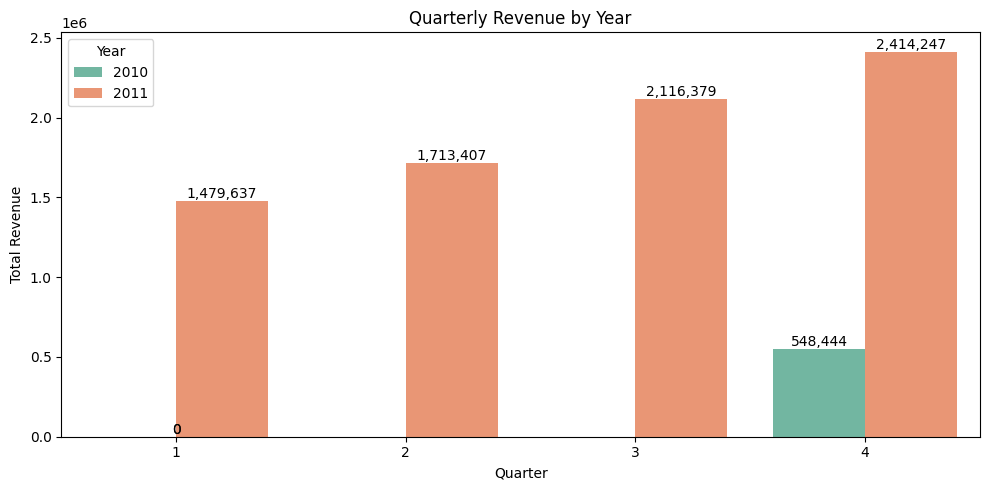

In [108]:
# Quarterly Revenue
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=Revenue_by_Quarter, x='Quarter', y='Revenue', hue='Year', palette='Set2')

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.title('Quarterly Revenue by Year')
plt.ylabel('Total Revenue')
plt.xlabel('Quarter')
plt.tight_layout()
plt.show()

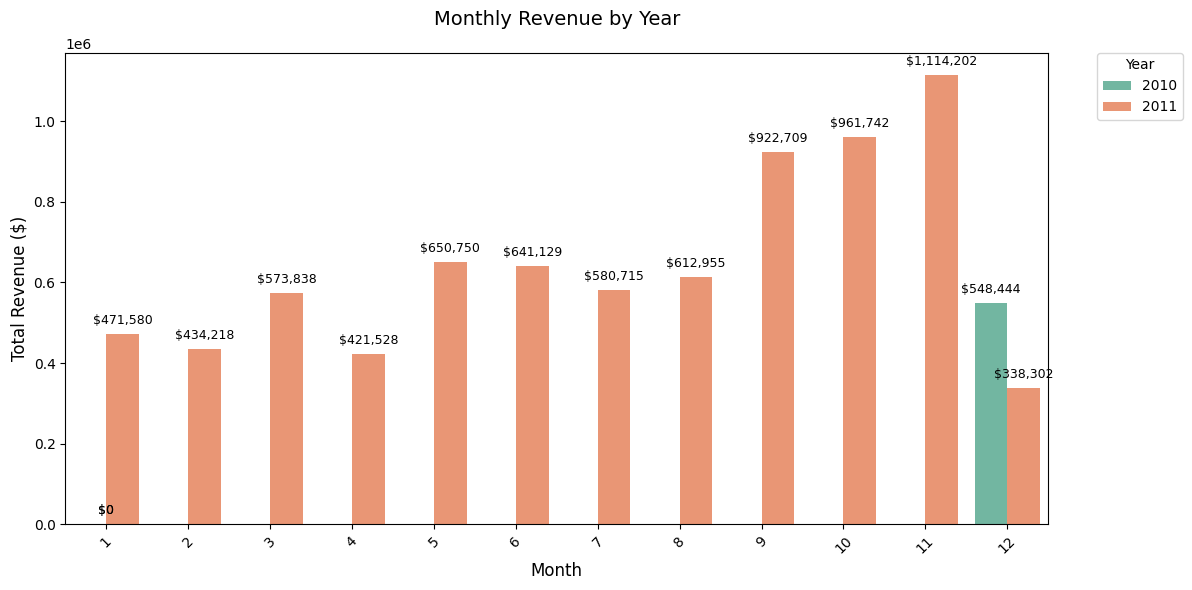

In [109]:
# Monthly Revenue
plt.figure(figsize=(12, 6))  # Slightly wider for better label spacing
ax = sns.barplot(data=Revenue_by_Month, x='Month', y='Revenue', hue='Year', palette='Set2')

# Add data labels to each bar
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):  # Skip NaN values
        ax.annotate(
            f'${height:,.0f}',  # Format as currency
            (p.get_x() + p.get_width() / 2., height),  # Position at bar center
            ha='center',  # Horizontal alignment
            va='bottom' if height >= 0 else 'top',  # Adjust for negative values
            xytext=(0, 5),  # 5 points vertical offset
            textcoords='offset points',
            fontsize=9,
            color='black'
        )

# Improve plot formatting
plt.title('Monthly Revenue by Year', pad=20, fontsize=14)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.xlabel('Month', fontsize=12)

# Improve legend placement
plt.legend(
    title='Year',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

# Rotate Month labels if crowded
plt.xticks(rotation=45 if len(Revenue_by_Month['Month'].unique()) > 6 else 0)

plt.tight_layout()
plt.show()

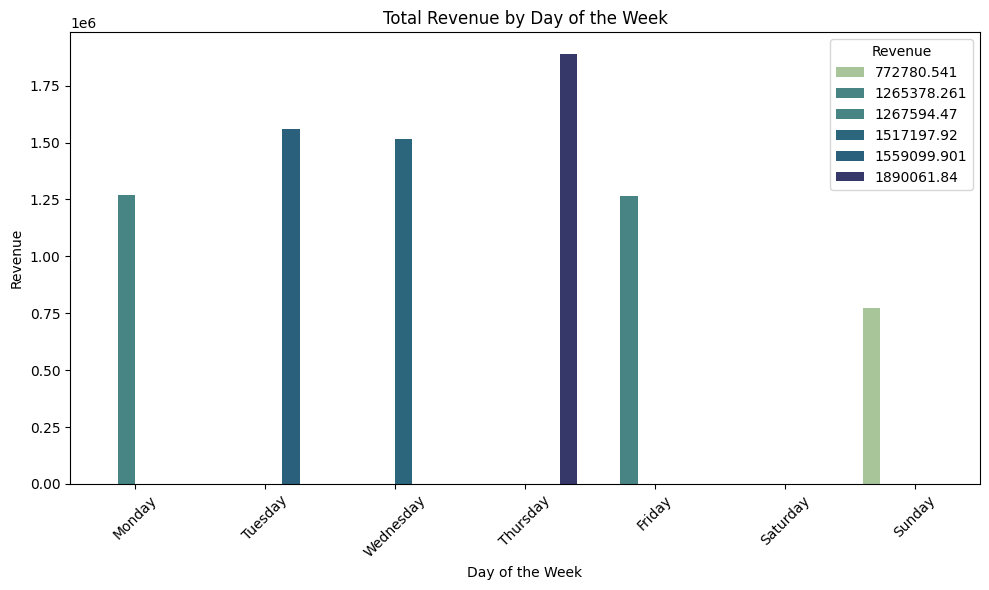

In [110]:
# Weekday Revenue
plt.figure(figsize=(10, 6))
sns.barplot(data=Revenue_by_weekday, x='WeekDay', y='Revenue',hue='Revenue', palette='crest')
plt.title('Total Revenue by Day of the Week')
plt.ylabel('Revenue')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [111]:
# Hourly Revenue
fig5 = px.line(Revenue_by_Hour.sort_values('Hour'), 
               x='Hour', 
               y='Revenue',
               text='Revenue',  # This adds the data labels
               title='Hourly Revenue', 
               labels={'Hour': 'Hour', 'Revenue': 'Total Revenue'})

# Customize the data labels
fig5.update_traces(texttemplate='%{text:.2s}',  # Format with 2 significant digits
                   textposition='top center')   # Position labels above the points

# Ensure every hour shows on x-axis
fig5.update_xaxes(dtick=1)

# Adjust layout to prevent label crowding
fig5.update_layout(uniformtext_minsize=8, 
                  uniformtext_mode='hide',
                  margin=dict(t=50))  # Add top margin for labels

fig5.show()

#### 4.2 Customer Analysis Visuals 

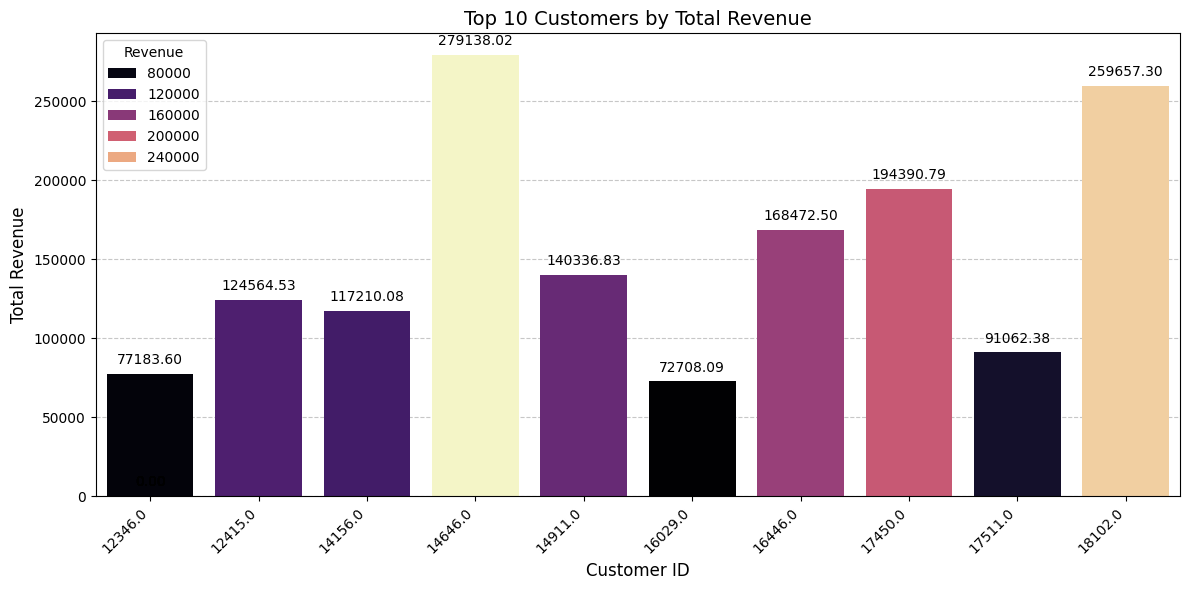

In [112]:
# Top 10 Customers by Total Revenue
plt.figure(figsize=(12, 6))  

ax = sns.barplot(data=Revenue_per_customer.head(10), 
                 x='CustomerID',  
                 y='Revenue', 
                 palette='magma', hue='Revenue', dodge=False)  

plt.title('Top 10 Customers by Total Revenue', fontsize=14)
plt.xlabel('Customer ID', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)

plt.xticks(rotation=45, ha='right') 
ax.xaxis.set_major_locator(plt.MaxNLocator(10)) 

ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=10)

plt.tight_layout() 
plt.show()

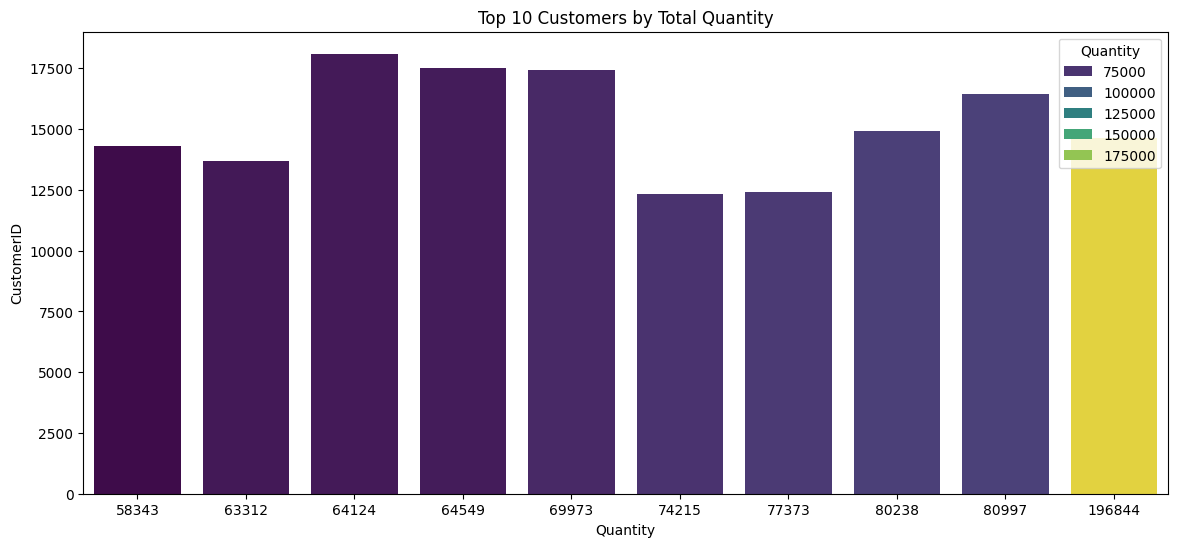

In [113]:
# Top 10 Customers by Total Quantity
plt.figure(figsize=(14, 6))
sns.barplot(data=quantity_per_customer.head(10), x='Quantity', y='CustomerID', palette='viridis', hue='Quantity')
plt.title('Top 10 Customers by Total Quantity')
plt.show()

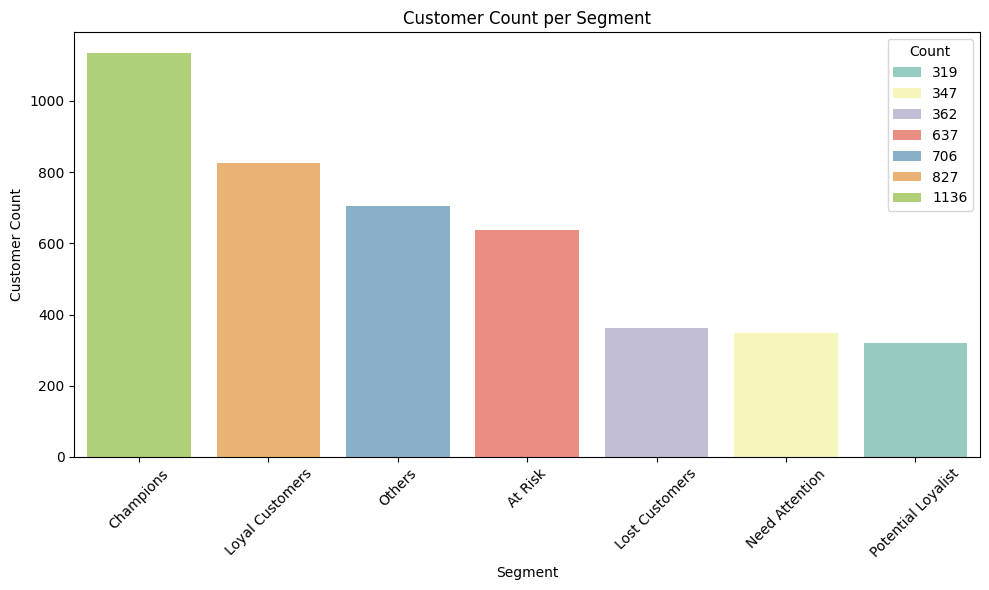

In [114]:
# Distribution of RFM Segments

segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(data=segment_counts, x='Segment', y='Count', palette='Set3', hue='Count')
plt.title('Customer Count per Segment')
plt.xlabel('Segment')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

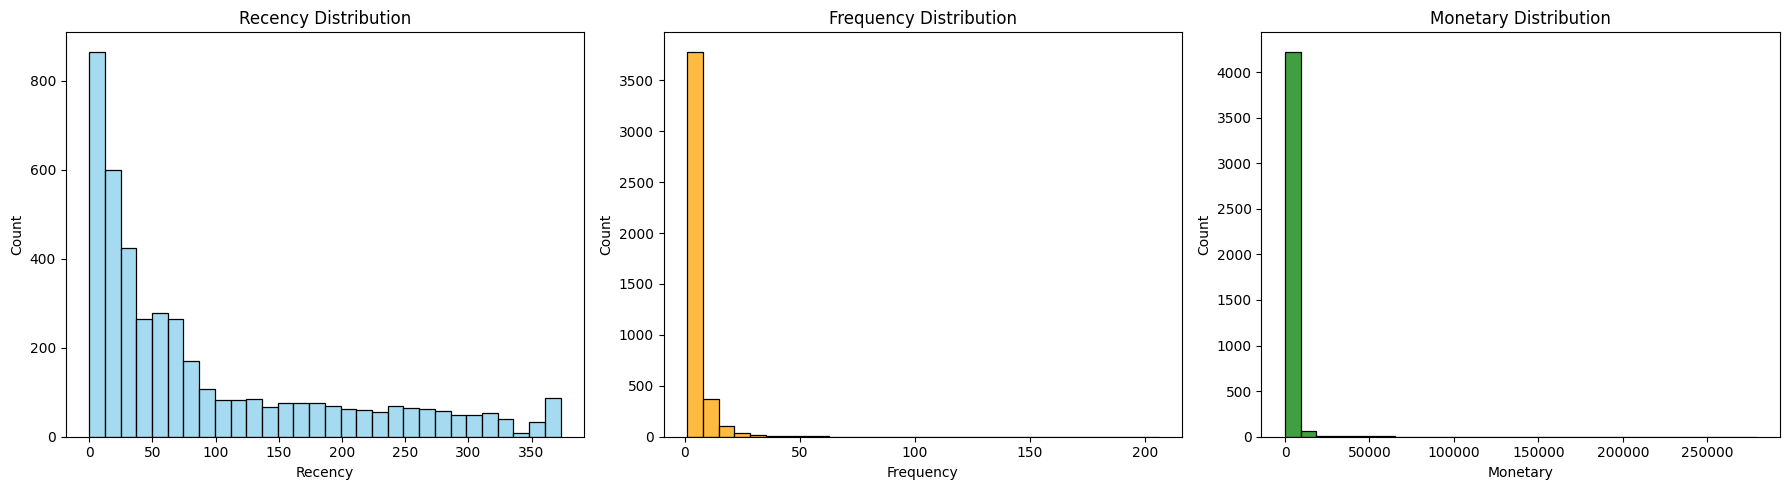

In [115]:
# Recency, Frequency, Monetary Distributions

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm['Recency'], bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=30, ax=axes[1], color='orange')
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins=30, ax=axes[2], color='green')
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()


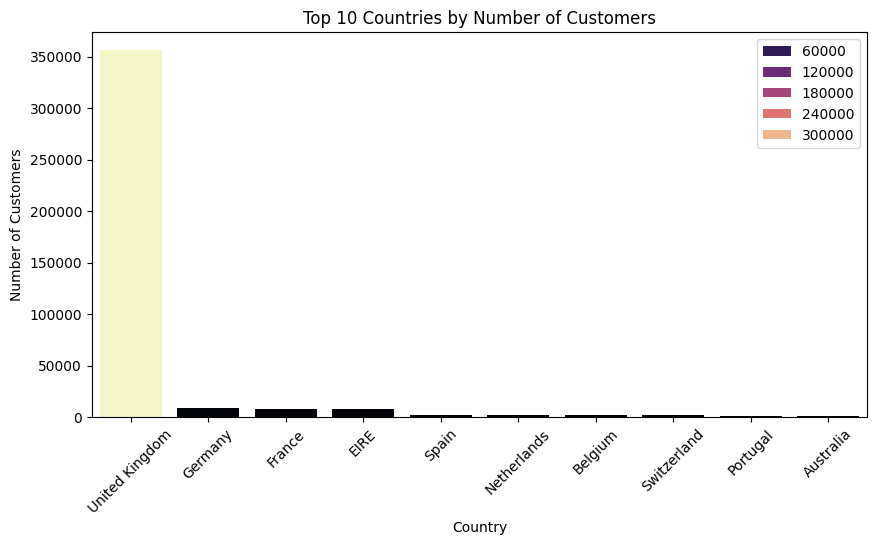

In [116]:
# Number of Customers per Country

top_countries = df['Country'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.index, y=top_countries.values, palette='magma', hue=top_countries.values)
plt.xticks(rotation=45)
plt.title('Top 10 Countries by Number of Customers')
plt.ylabel('Number of Customers')
plt.xlabel('Country')
plt.show()


#### 4.3 Product Analysis Visuals

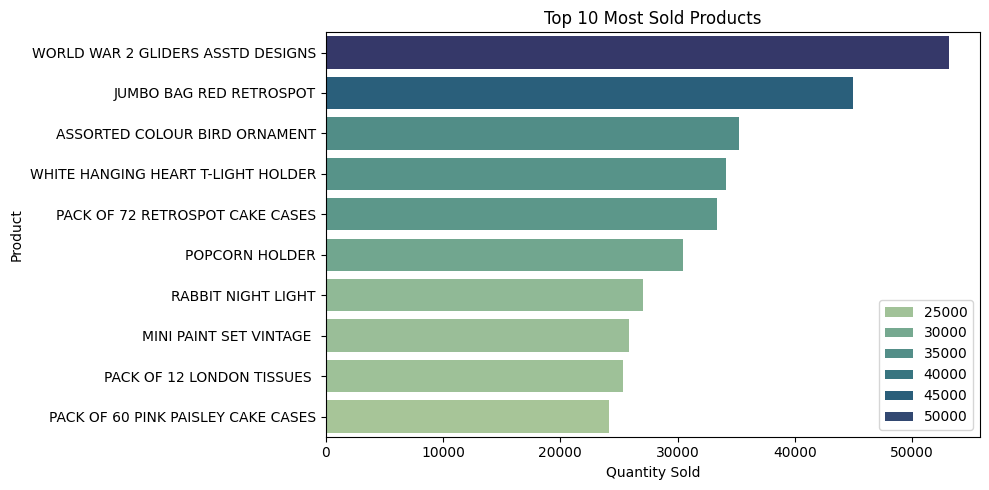

In [117]:
# Top 10 Sold Products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index, palette='crest', hue= top_products.values) 
plt.title('Top 10 Most Sold Products')
plt.xlabel('Quantity Sold')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

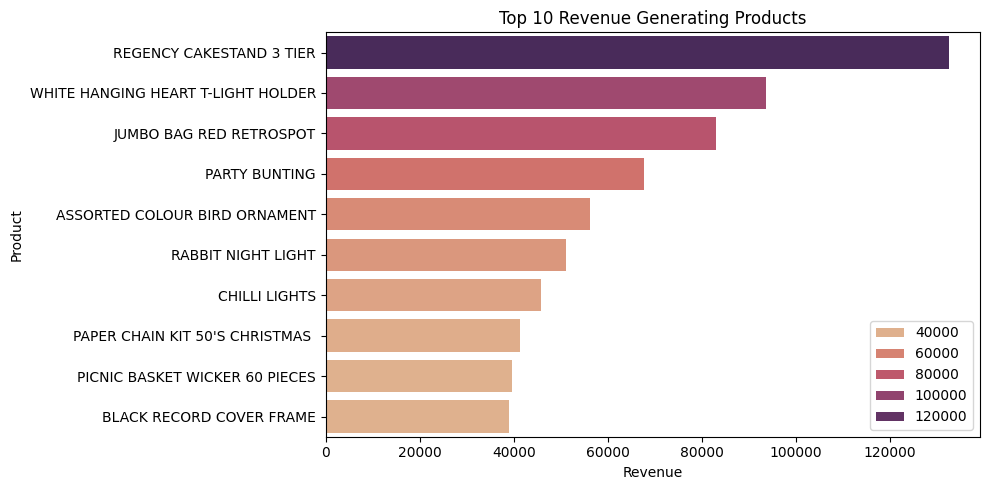

In [118]:
# top 10 Revenue products
top_Revenue_products = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_Revenue_products.values, y=top_Revenue_products.index, palette='flare', hue= top_Revenue_products.values)
plt.title('Top 10 Revenue Generating Products')
plt.xlabel('Revenue')
plt.ylabel('Product')
plt.tight_layout()
plt.show()


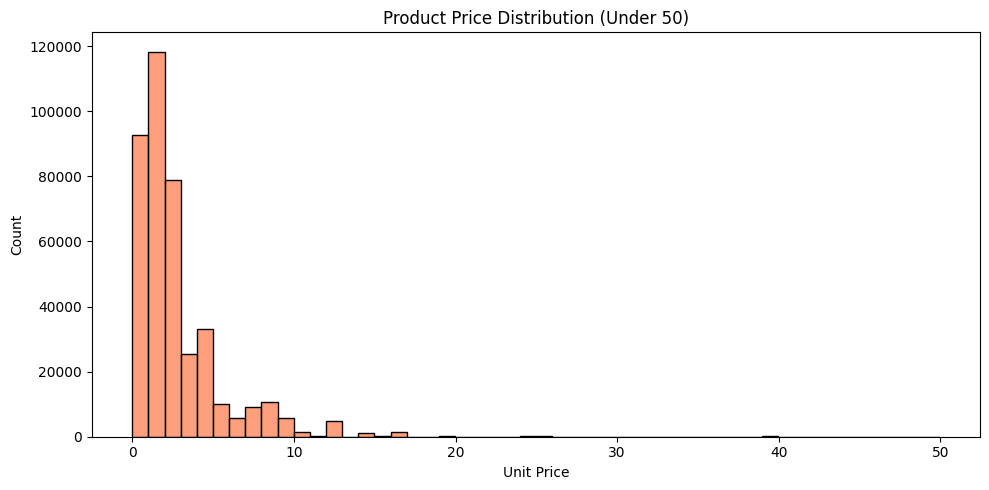

In [119]:
# Price Distribution
plt.figure(figsize=(10,5))
sns.histplot(df[df['UnitPrice'] < 50]['UnitPrice'], bins=50, color='coral')
plt.title('Product Price Distribution (Under 50)')
plt.xlabel('Unit Price')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### 4.4 Country Analysis Visuals

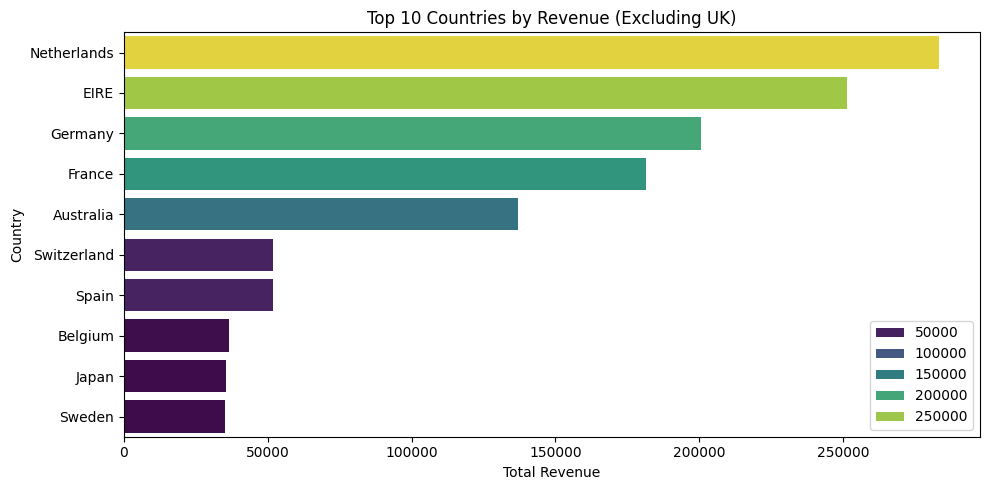

In [120]:
# Total Revenue by Country (excluding UK)
country_Revenue = df[df['Country'] != 'United Kingdom'].groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=country_Revenue.values, y=country_Revenue.index, palette='viridis', hue=country_Revenue.values)
plt.title('Top 10 Countries by Revenue (Excluding UK)')
plt.xlabel('Total Revenue')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


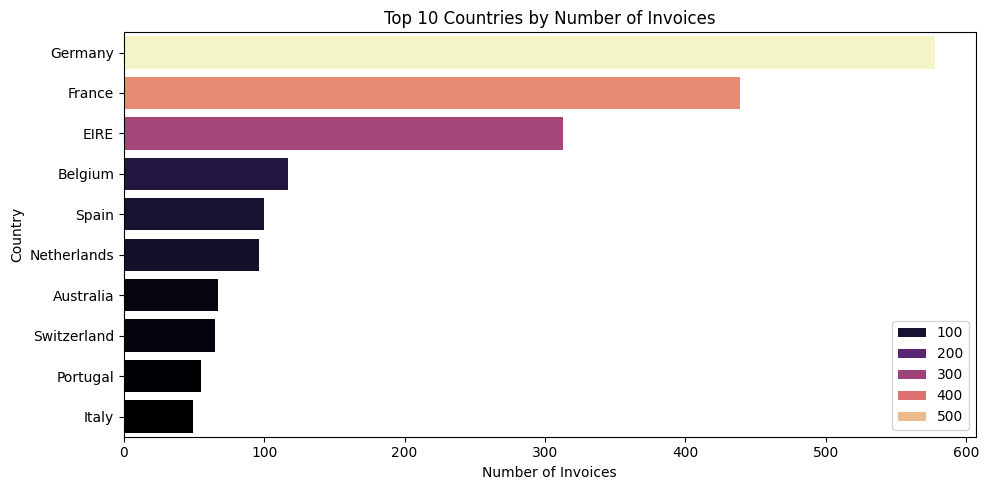

In [121]:
# Number of Invoices per Country (excluding UK)
invoice_counts = df[df['Country'] != 'United Kingdom'].groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=invoice_counts.values, y=invoice_counts.index, palette='magma', hue=invoice_counts.values)
plt.title('Top 10 Countries by Number of Invoices')
plt.xlabel('Number of Invoices')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


C:\Users\ahmed eissa\AppData\Local\Temp\ipykernel_13360\2448067459.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



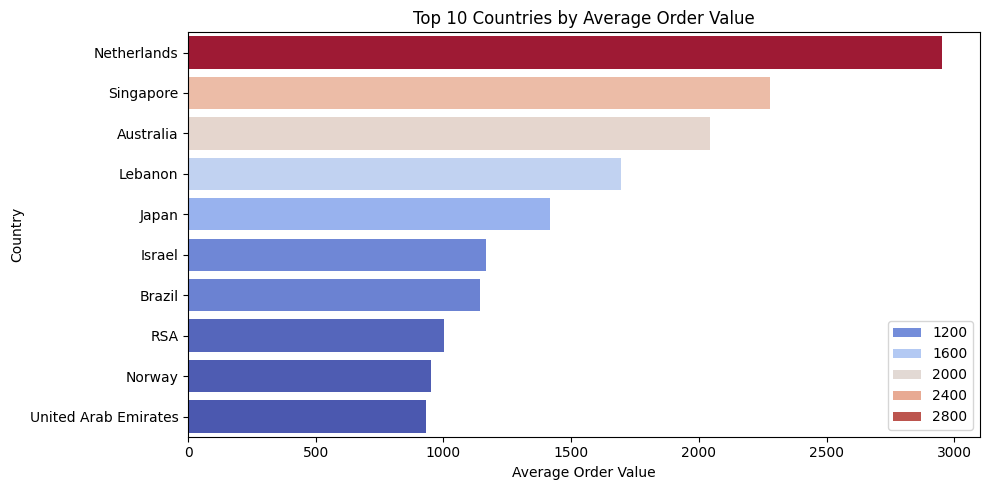

In [122]:
# Average Order Value per Country
avg_order_value = df[df['Country'] != 'United Kingdom'].groupby('Country').apply(lambda x: (x['Revenue'].sum() / x['InvoiceNo'].nunique())).sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=avg_order_value.values, y=avg_order_value.index, palette='coolwarm', hue=avg_order_value.values)  
plt.title('Top 10 Countries by Average Order Value')
plt.xlabel('Average Order Value')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


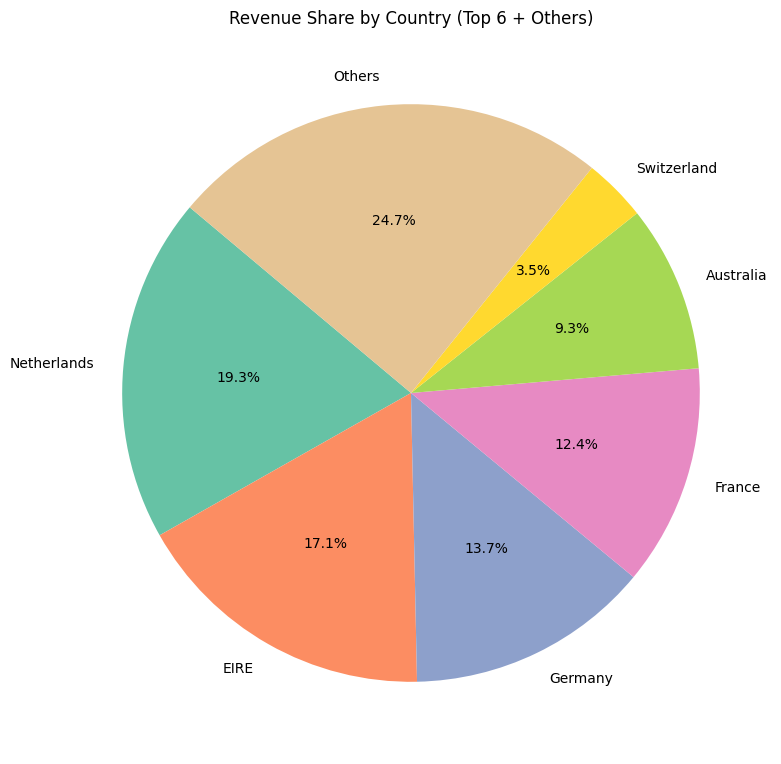

In [123]:
# Revenue Distribution by Country (Pie Chart)
top_countries = df[df['Country'] != 'United Kingdom'].groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(6)
others = df[~df['Country'].isin(top_countries.index) & (df['Country'] != 'United Kingdom')]['Revenue'].sum()
top_countries['Others'] = others

plt.figure(figsize=(8,8))
plt.pie(top_countries, labels=top_countries.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Revenue Share by Country (Top 6 + Others)')
plt.tight_layout()
plt.show()


#### 4.5 Returns Analysis Visuals

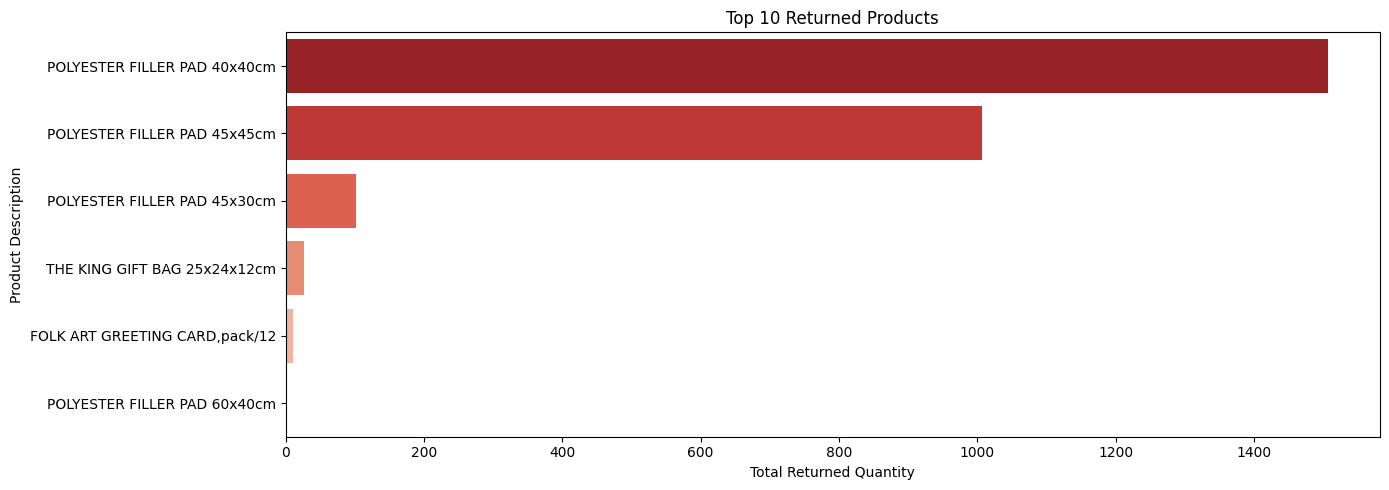

In [130]:
# Top returned products 

plt.figure(figsize=(14,5))
sns.barplot(x=top_returned_products.values, y=top_returned_products.index, palette='Reds_r', hue=top_returned_products.index)
plt.title('Top 10 Returned Products')
plt.xlabel('Total Returned Quantity')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()


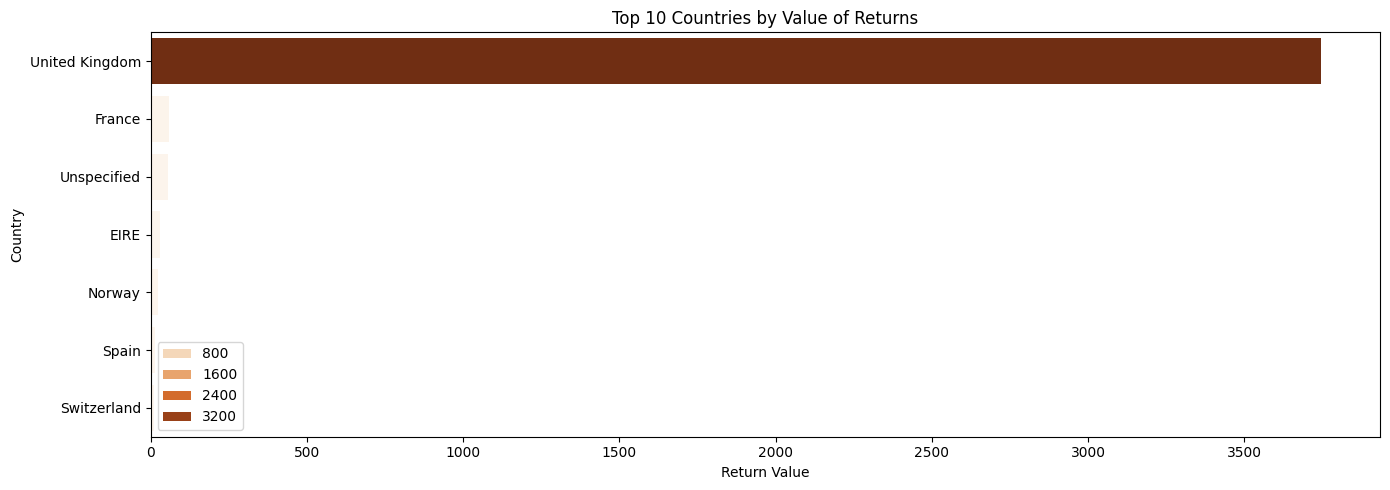

In [131]:
returns_by_country = df[df['Description'].str.contains("c")].groupby('Country')['Revenue'].sum().abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(14,5))
sns.barplot(x=returns_by_country.values, y=returns_by_country.index, palette='Oranges', hue=returns_by_country.values)
plt.title('Top 10 Countries by Value of Returns')
plt.xlabel('Return Value')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


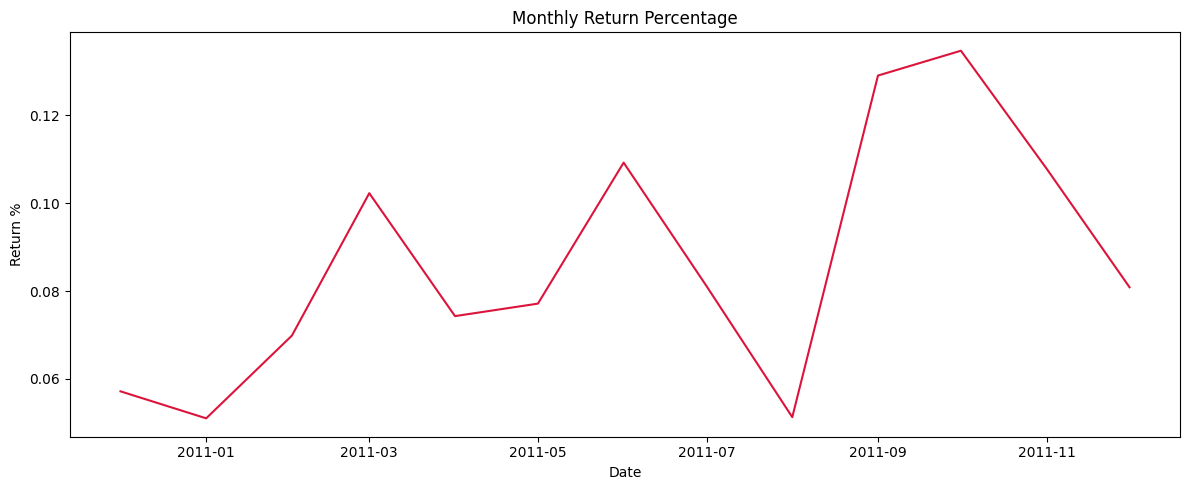

In [132]:
# Monthly Return Percentage

plt.figure(figsize=(12, 5))
sns.lineplot(data=Monthly_returns, x='Date', y='return_percent', color='crimson')
plt.title('Monthly Return Percentage')
plt.xlabel('Date')
plt.ylabel('Return %')
plt.tight_layout()
plt.show()

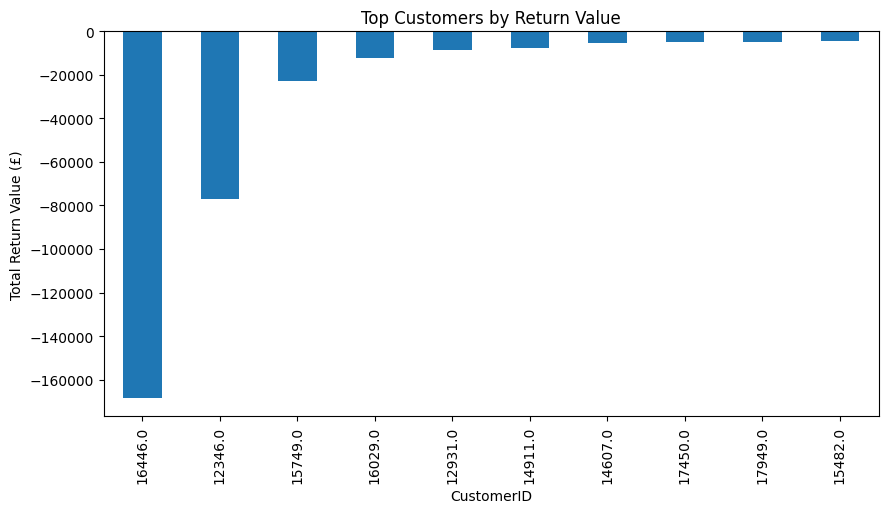

In [133]:
top_return_customers.plot(kind='bar', figsize=(10, 5), title="Top Customers by Return Value")
plt.ylabel("Total Return Value (£)")
plt.show()

## 📌 5. Summary & Insights & Final Recommendations

### 5.1 Summary 

- Sales Data Analysis for an E-commerce Store.
- Analyzed sales transactions from December 2010 to December 2011.
- Original dataset: Approximately 540,000 rows.
- Cleaned data by removing null values and duplicate entries.
- Created new calculated columns including.
- Excluded records without CustomerID to facilitate customer analysis.

##### Performed Analyses:

- Product Analysis

- Country-wise Analysis

- Customer Segmentation

- Invoice Analysis

- Monthly Time Series Analysis

- Returns Analysis

### 5.2 Insights

#### 1. Introduction
This notebook documents the entire workflow, from cleaning the data to performing exploratory data analysis and drawing actionable insights.

---

#### 2. Data Cleaning
- Removed duplicates and missing values.
- Converted date columns to datetime.
- Created new columns.

---

#### 3. Invoice Analysis:
- High variation in invoice values.
- Some invoices include returns, impacting net revenue.
- Total valid invoices: **4334**.

---

#### 4. Time Series Analysis
-- **November** had the highest sales, while **April** had the lowest.
- Peak sales day: **Thursday at 12 PM**.
- No sales on **Saturdays**, indicating store closure.
- Sales grow each quarter compared to the last, and Q4 2010 sales were less than half of Q4 2011 sales.

---

#### 5. Customer Segmentation (RFM Analysis)
- **1136 Champions**
- **827 Loyal Customers**
- Majority fall into the "Others" segment, indicating weak engagement.

---

#### 6. Product Analysis
- Products such as PARTY BUNTING, WHITE HANGING HEART T-LIGHT HOLDER, and LUNCH BAG RED RETROSPOT were among the highest in frequency and sales.
- Price variance found in identical product descriptions.

---

#### 7. Market Analysis
- Netherlands had highest average invoice value.
- **UK** is the dominant market.
- **Netherlands** has strong sales but is highly dependent on one customer.

---

#### 8. Dashboard Visualizations
- Included key charts for business understanding
  - Sales trends
  - Customer distribution
  - Product performance

### 5.3 Final Recommendations

1. **Stock Management & Seasonal Planning**:
   - Focus on November with optimized promotional campaigns.

2. **Retarget High-Value Customers**:
   - Personalized offers for Champions & Loyal Customers.

3. **Price Clarification**:
   - Review and clarify products with varying prices under the same name.

4. **Market Expansion**:
   - Explore expansion opportunities in countries like the Netherlands, while reducing dependency on single clients.

5. **Reduce Returns**:
   - Investigate high-return products and address quality or description issues.

- Focus marketing campaigns/promotions on midweek (especially Thursday) during peak hours.
- Retain loyal customers with exclusive offers or reward points.
- Launch reactivation campaigns for "At Risk" and "Lost Customers.
- Stabilize pricing for bestsellers to maintain customer trust.
- Promote low-demand products to loyal customers or in seasonal campaigns.
- Expand UK reach via personalization and deeper segmentation.
- Target paid campaigns in the Netherlands to grow market share.
- Audit quality of frequently returned products.
- Monitor behavior of customers with repeat returns.

1. Temporal Analysis – Sales Timing

✅ Recommendations:

Launch marketing campaigns/discounts starting October, intensifying in November.

Focus efforts on high-volume weekdays (e.g., Thursday).

Leverage the daily peak (10 AM–2 PM) for timed promotions or flash sales.


2. Invoice Analysis & Purchase Behavior

✅ Recommendations:

Review return policies to reduce returns and identify root causes.

Introduce a Wholesale Program for bulk buyers.


3. Customer Segments (RFM Analysis)

✅ Recommendations:

Run exclusive loyalty programs/discounts for Champions.

Re-engage "At Risk" customers with reminder emails/coupons.

Launch retargeting campaigns for Lost Customers.


4. Product Performance & Pricing

✅ Recommendations:

Feature bestsellers prominently (e.g., homepage/offers).

Audit pricing strategy to ensure consistency.

Create product bundles for frequently co-purchased items.


5. Market (Country) Analysis

✅ Recommendations:

Enhance UK customer experience with localized offers.

Target Netherlands with focused campaigns to expand market share.

Address shipping/payment issues in underperforming markets.

كدا ناقص ظبط كود المرتجعات ومراجعة شات جي بي تي وملاحظاته اللي قالها 
وكمان الداشبورد, وكمان عمل الsummary